In [10]:
# ====================================================
# XGBoost CPU vs GPU Optimization on NYC Taxi Dataset
# Author: Anirudh Krishna
# ====================================================

In [11]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

In [12]:
# ----------------------------
# Step 1: Load 200,000 rows
# ----------------------------
chunk = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/train.csv", chunksize=200000)
df = next(chunk)

# ---------------------------------------
# Step 2: Preprocessing & Feature Prep
# ---------------------------------------
# Drop columns that can't be used directly
df.drop(['id', 'pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)

# Convert 'store_and_fwd_flag' to numeric
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Remove extreme trip durations (optional but improves model)
df = df[df['trip_duration'] < 100000]

# Separate features and target
X = df.drop('trip_duration', axis=1)
y = df['trip_duration']
y_log = np.log1p(y)  # log-transform to reduce skew for RMSLE

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [13]:
# --------------------------------------
# Step 3: CPU-Based XGBoost Training
# --------------------------------------
print("Training on CPU...")
start_cpu = time.time()

model_cpu = XGBRegressor(
    tree_method='hist',  # Efficient CPU method
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)
model_cpu.fit(X_train, y_train)

end_cpu = time.time()
cpu_time = end_cpu - start_cpu

preds_cpu = model_cpu.predict(X_test)
rmsle_cpu = np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds_cpu)))

Training on CPU...


In [14]:
# --------------------------------------
# Step 4: GPU-Based XGBoost Training
# --------------------------------------
print("Training on GPU...")

# Convert data to numpy to avoid memory device mismatch
X_train_gpu = X_train.to_numpy()
X_test_gpu = X_test.to_numpy()

start_gpu = time.time()

model_gpu = XGBRegressor(
    tree_method='hist',
    device='cuda',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)
model_gpu.fit(X_train_gpu, y_train)

end_gpu = time.time()
gpu_time = end_gpu - start_gpu

preds_gpu = model_gpu.predict(X_test_gpu)
rmsle_gpu = np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds_gpu)))

Training on GPU...



 Benchmark Results:


,Mode,Training Time (s),RMSLE
0,CPU,0.783026,0.519404
1,GPU,0.386987,0.522331


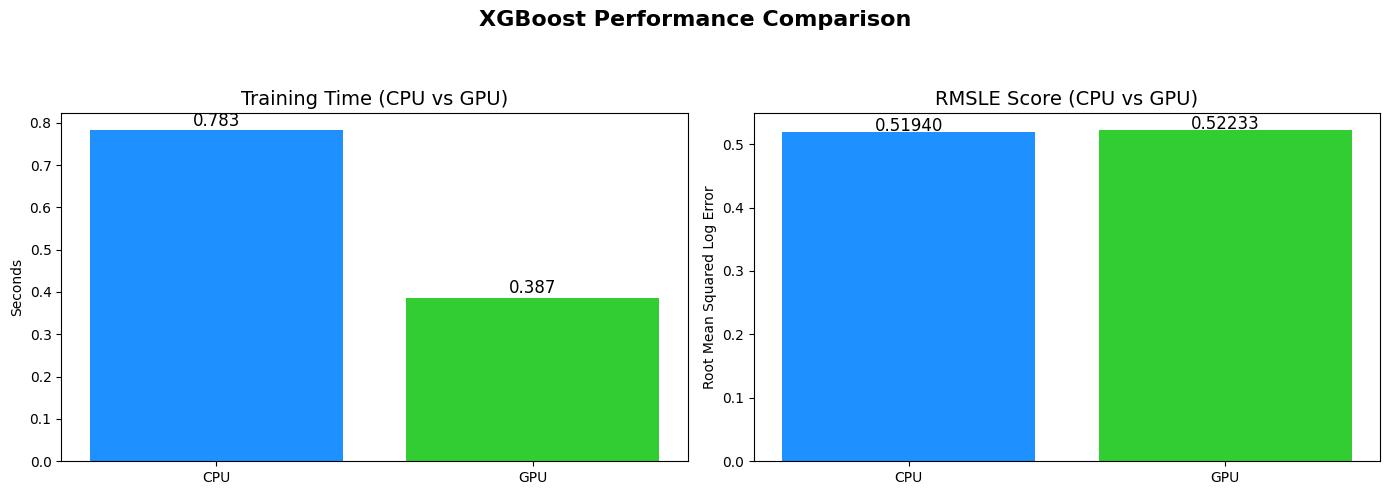

In [17]:
# --------------------------------------
# Step 5: Comparison Summary
# --------------------------------------
import matplotlib.pyplot as plt

# Updated results for cleaner formatting
results = pd.DataFrame({
    'Mode': ['CPU', 'GPU'],
    'Training Time (s)': [cpu_time, gpu_time],
    'RMSLE': [rmsle_cpu, rmsle_gpu]
})

print("\n Benchmark Results:")
display(results)

# Setup plots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Time
bars1 = axs[0].bar(results['Mode'], results['Training Time (s)'], color=['dodgerblue', 'limegreen'])
axs[0].set_title('Training Time (CPU vs GPU)', fontsize=14)
axs[0].set_ylabel('Seconds')
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", ha='center', fontsize=12)

# Plot 2: RMSLE
bars2 = axs[1].bar(results['Mode'], results['RMSLE'], color=['dodgerblue', 'limegreen'])
axs[1].set_title('RMSLE Score (CPU vs GPU)', fontsize=14)
axs[1].set_ylabel('Root Mean Squared Log Error')
for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, height + 0.0015, f"{height:.5f}", ha='center', fontsize=12)

# Overall layout
plt.suptitle('XGBoost Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
